<a href="https://colab.research.google.com/github/mariusbiteau/Buildings_Electrical-Consumption_CO2-Emissions_Prediction/blob/main/Analysis_Buildings_Electrical_Consumption_CO2_Emissions_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of electrical consumption and CO2 emissions of non-residential buildings.

You work for the city of Seattle. To achieve its goal of a carbon-neutral city by 2050, your team is taking a close look at emissions from non-residential buildings.

### About the Dataset

This is a dataset hosted by the City of Seattle. The city has an open data platform found here and they update their information according the amount of data that is brought in. 

Update Frequency: This dataset is updated quarterly.

The datasets has as datapoint each building (3102 buildings) and for each, we have 21 columns that describes the informations of the building


### Project Goal

Thorough surveys have been carried out by Seattle agents in 2015 and 2016. However, these readings are expensive to obtain, and based on those already taken, Seattle want to try to predict the CO2 emissions and total energy consumption of buildings for which they have not yet been measured.

You are also looking to assess the value of the ENERGY STAR Score for emissions prediction, which is tedious to calculate with the approach Seattle's team is currently using.

Objectives of this analysis notebook :

- Perform a brief EDA.
- Test different prediction models in order to better answer the problem.

In [61]:
# Essentials
from google.colab import drive
import pandas as pd
import numpy as np
import json
import time
import six

# Plots
import seaborn as sns
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Stats
import math
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

# Misc
from sklearn import metrics
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Execution Time
!pip install ipython-autotime
%load_ext autotime

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.76 s (started: 2021-01-31 12:40:53 +00:00)


## 1. Data Import

In [62]:
drive.mount('/content/drive')
csv_seattle = '/content/drive/My Drive/OC_DataScientist/P4/df_seattle_modelization.csv'
df = pd.read_csv(csv_seattle)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 21.6 ms (started: 2021-01-31 12:40:56 +00:00)


## 2. Data Description

##### Show data header


In [63]:
df.head(3)

,Unnamed: 0,OSEBuildingID,DataYear,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
0,0,1,2015,MAYFLOWER PARK HOTEL,88,Hotel,1.0,4.0,88434,1.000000,65.0,Electricity,6981428.0,0.527995,0.182253,0.289773,0.0,249.43,7,47.612190,-122.337997
1,1,2,2015,PARAMOUNT HOTEL,19,Hotel,1.0,4.0,103566,0.854547,51.0,NaturalGas,8354235.0,0.467477,0.532542,0.000000,0.0,263.51,7,47.613106,-122.333358
2,2,3,2015,WESTIN HOTEL,46,Hotel,1.0,4.0,961990,1.000000,18.0,Electricity,73130656.0,0.680459,0.050730,0.268839,0.0,2061.48,7,47.613349,-122.337699


time: 21.4 ms (started: 2021-01-31 12:40:56 +00:00)


##### Show data info


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    3102 non-null   int64  
 1   OSEBuildingID                 3102 non-null   int64  
 2   DataYear                      3102 non-null   int64  
 3   PropertyName                  3102 non-null   object 
 4   BuildingAge                   3102 non-null   int64  
 5   PrimaryPropertyType           3102 non-null   object 
 6   NumberofBuildings             3102 non-null   float64
 7   Binned_Floors                 3079 non-null   float64
 8   PropertyGFATotal              3102 non-null   int64  
 9   GFABuildings_prop             3102 non-null   float64
 10  ENERGYSTARScore               2065 non-null   float64
 11  MainEnergy                    3102 non-null   object 
 12  SiteEnergyUse(kBtu)           3102 non-null   float64
 13  Ele

##### Fix data types


In [65]:
df.PropertyName = df.PropertyName.astype('category')
df.PrimaryPropertyType = df.PrimaryPropertyType.astype('category')
df.MainEnergy = df.MainEnergy.astype('category')
df = df.drop(['Unnamed: 0'], axis=1)

time: 21.3 ms (started: 2021-01-31 12:40:56 +00:00)


Now, let's check our new data types and column names:

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OSEBuildingID                 3102 non-null   int64   
 1   DataYear                      3102 non-null   int64   
 2   PropertyName                  3102 non-null   category
 3   BuildingAge                   3102 non-null   int64   
 4   PrimaryPropertyType           3102 non-null   category
 5   NumberofBuildings             3102 non-null   float64 
 6   Binned_Floors                 3079 non-null   float64 
 7   PropertyGFATotal              3102 non-null   int64   
 8   GFABuildings_prop             3102 non-null   float64 
 9   ENERGYSTARScore               2065 non-null   float64 
 10  MainEnergy                    3102 non-null   category
 11  SiteEnergyUse(kBtu)           3102 non-null   float64 
 12  Electricity                   3102 non-null   fl

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [67]:
df.describe()

,OSEBuildingID,DataYear,BuildingAge,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
count,3102.000000,3102.000000,3102.000000,3102.000000,3079.000000,3.102000e+03,3102.000000,2065.000000,3.102000e+03,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000
mean,15920.698259,2015.485816,53.815603,1.089297,2.443326,1.145883e+05,0.934572,63.848426,8.030760e+06,0.706203,0.273337,0.020395,0.000044,178.629001,4.382979,47.615868,-122.333445
std,13331.224511,0.499879,32.743955,1.169077,1.129937,1.977410e+05,0.150500,28.738155,2.082894e+07,0.260824,0.261913,0.089330,0.001321,657.974395,2.202357,0.047740,0.023942
min,1.000000,2015.000000,1.000000,0.000000,1.000000,1.128500e+04,-1.502318,1.000000,1.144100e+04,0.000000,0.000000,0.000000,0.000000,0.080000,1.000000,47.509435,-122.411820
25%,586.500000,2015.000000,27.000000,1.000000,1.000000,2.938000e+04,1.000000,45.000000,1.228871e+06,0.498926,0.000000,0.000000,0.000000,19.822500,2.000000,47.585957,-122.343233
50%,21125.000000,2015.000000,50.000000,1.000000,2.000000,4.885000e+04,1.000000,71.000000,2.602079e+06,0.721463,0.231826,0.000000,0.000000,49.060000,4.000000,47.612276,-122.333223
75%,24535.500000,2016.000000,86.000000,1.000000,3.000000,1.046775e+05,1.000000,88.000000,7.141995e+06,0.999998,0.484631,0.000000,0.000000,140.640000,7.000000,47.648351,-122.322623
max,50226.000000,2016.000000,116.000000,39.000000,4.000000,2.200000e+06,1.000029,100.000000,4.483853e+08,1.000087,1.000000,0.830998,0.046463,16870.980000,7.000000,47.733870,-122.258795


time: 86.6 ms (started: 2021-01-31 12:40:56 +00:00)


##### Show if there are missing datapoints¶


In [68]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

OSEBuildingID , 0.0
DataYear , 0.0
PropertyName , 0.0
BuildingAge , 0.0
PrimaryPropertyType , 0.0
NumberofBuildings , 0.0
Binned_Floors , 0.74
PropertyGFATotal , 0.0
GFABuildings_prop , 0.0
ENERGYSTARScore , 33.43
MainEnergy , 0.0
SiteEnergyUse(kBtu) , 0.0
Electricity , 0.0
NaturalGas , 0.0
SteamUse , 0.0
OtherFuelUse , 0.0
GHGEmissions(MetricTonsCO2e) , 0.0
CouncilDistrictCode , 0.0
Latitude , 0.0
Longitude , 0.0
time: 14.2 ms (started: 2021-01-31 12:40:56 +00:00)


In [69]:
print(df.isnull().sum())

OSEBuildingID                      0
DataYear                           0
PropertyName                       0
BuildingAge                        0
PrimaryPropertyType                0
NumberofBuildings                  0
Binned_Floors                     23
PropertyGFATotal                   0
GFABuildings_prop                  0
ENERGYSTARScore                 1037
MainEnergy                         0
SiteEnergyUse(kBtu)                0
Electricity                        0
NaturalGas                         0
SteamUse                           0
OtherFuelUse                       0
GHGEmissions(MetricTonsCO2e)       0
CouncilDistrictCode                0
Latitude                           0
Longitude                          0
dtype: int64
time: 5.72 ms (started: 2021-01-31 12:40:56 +00:00)


[Text(30.5, 0.5, 'Data Points'),
 Text(0.5, 11.59375, 'Columns'),
 Text(0.5, 1.0, 'Missing Data')]

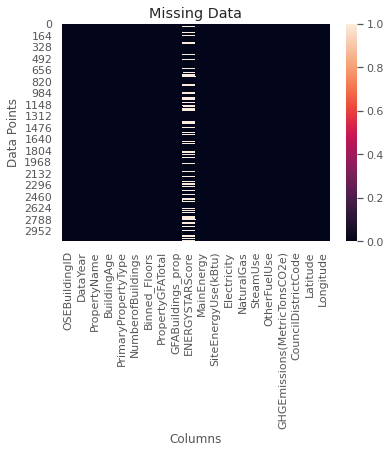

time: 652 ms (started: 2021-01-31 12:40:56 +00:00)


In [70]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

We can see from above that we have some missing data points, but it is not extensive and it mainly concerns the energystar score feature.

We will now process these missing data points

## 3. Data Cleaning

### 3.1 Missing Values

- Binned_Floors: 23 missing data points. These can be manually check through online search of images or public data to have the floor class of the building.
- ENERGYSTARScore: 1037 missing data points. One of the objectives is to evaluate the interest of the ENERGY STAR Score for the prediction of emissions, therefore we need to keep only individual with energy star score.

##### Binned Floors


In [71]:
df.loc[df['Binned_Floors'].isnull()]

,OSEBuildingID,DataYear,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
154,267,2015,PINE ST. CONDO-ELLIOTT GRAND HYATT SEATTLE,16,Hotel,1.0,NaN,934292,1.000000,NaN,Electricity,63811044.00,0.621648,0.378378,0.000000,0.0,1558.85,7,47.612677,-122.333932
464,656,2015,1221 MADISON STREET (FORMER ARNOLD MED. PAVILLON),11,Office,1.0,NaN,225982,1.000000,61.0,Electricity,18558162.00,0.635452,0.000000,0.364574,0.0,604.45,3,47.609680,-122.323105
465,657,2015,2200 WESTLAKE,9,Other,1.0,NaN,516407,1.000000,19.0,Electricity,48981052.00,0.610087,0.389938,0.000000,0.0,1222.69,7,47.617939,-122.337387
536,758,2015,PACIFIC PLACE,16,Other,1.0,NaN,947987,0.535663,NaN,Electricity,48143224.00,1.000041,0.000000,0.000000,0.0,335.63,7,47.612874,-122.335276
1137,24086,2015,KING COUNTY METRO TRANSIT ATLANTIC-CENTRAL BAS...,24,Other,10.0,NaN,180796,1.000000,NaN,Electricity,29939196.00,0.558467,0.441556,0.000000,0.0,818.66,2,47.591130,-122.323399
1538,40028,2015,"SAND POINT BUILDING 5A,5B,5C,5D",75,Warehouse,1.0,NaN,384772,1.000000,65.0,Electricity,15411831.00,0.579122,0.420902,0.000000,0.0,406.74,4,47.683844,-122.261760
1539,40031,2015,SAND POINT BUILDING 25,55,Office,1.0,NaN,30287,1.000000,56.0,Electricity,1976647.00,0.845482,0.154553,0.000000,0.0,27.88,4,47.682195,-122.262390
1540,40034,2015,SAND POINT BUILDING 29,55,Office,1.0,NaN,21931,1.000000,21.0,NaturalGas,3732139.00,0.351837,0.648178,0.000000,0.0,137.63,4,47.682195,-122.262946
1546,43948,2015,GEORGETOWN STEAM PLANT,109,Other,1.0,NaN,39212,1.000000,NaN,Electricity,773013.00,1.000041,0.000000,0.000000,0.0,5.39,2,47.561588,-122.316071
1555,49705,2015,MAGNUSON PARK CAMPUS,86,Other,7.0,NaN,502030,1.000000,NaN,Electricity,17290816.00,0.558767,0.441256,0.000000,0.0,472.56,4,47.683179,-122.258795


time: 37.4 ms (started: 2021-01-31 12:40:57 +00:00)


In [72]:
df.loc[df["OSEBuildingID"] == 267,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 656,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 657,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 758,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 21611,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 24086,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 40028,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 40031,"Binned_Floors"] = 3
df.loc[df["OSEBuildingID"] == 40034,"Binned_Floors"] = 3
df.loc[df["OSEBuildingID"] == 49705,"Binned_Floors"] = 1
df.loc[df["OSEBuildingID"] == 43948,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 49958,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 49966,"Binned_Floors"] = 1
df.loc[df["OSEBuildingID"] == 23311,"Binned_Floors"] = 4

time: 26.4 ms (started: 2021-01-31 12:40:57 +00:00)


 ##### Energy Star Score


In [73]:
df = df[df.ENERGYSTARScore.notna()]
df.shape

(2065, 20)

time: 6.8 ms (started: 2021-01-31 12:40:57 +00:00)


Let's check our missing data if any:



In [74]:
print(df.isnull().sum())

OSEBuildingID                   0
DataYear                        0
PropertyName                    0
BuildingAge                     0
PrimaryPropertyType             0
NumberofBuildings               0
Binned_Floors                   0
PropertyGFATotal                0
GFABuildings_prop               0
ENERGYSTARScore                 0
MainEnergy                      0
SiteEnergyUse(kBtu)             0
Electricity                     0
NaturalGas                      0
SteamUse                        0
OtherFuelUse                    0
GHGEmissions(MetricTonsCO2e)    0
CouncilDistrictCode             0
Latitude                        0
Longitude                       0
dtype: int64
time: 4.1 ms (started: 2021-01-31 12:40:57 +00:00)


## 4. EDA

### 4.1 Univariate Analysis: Numerical Variable

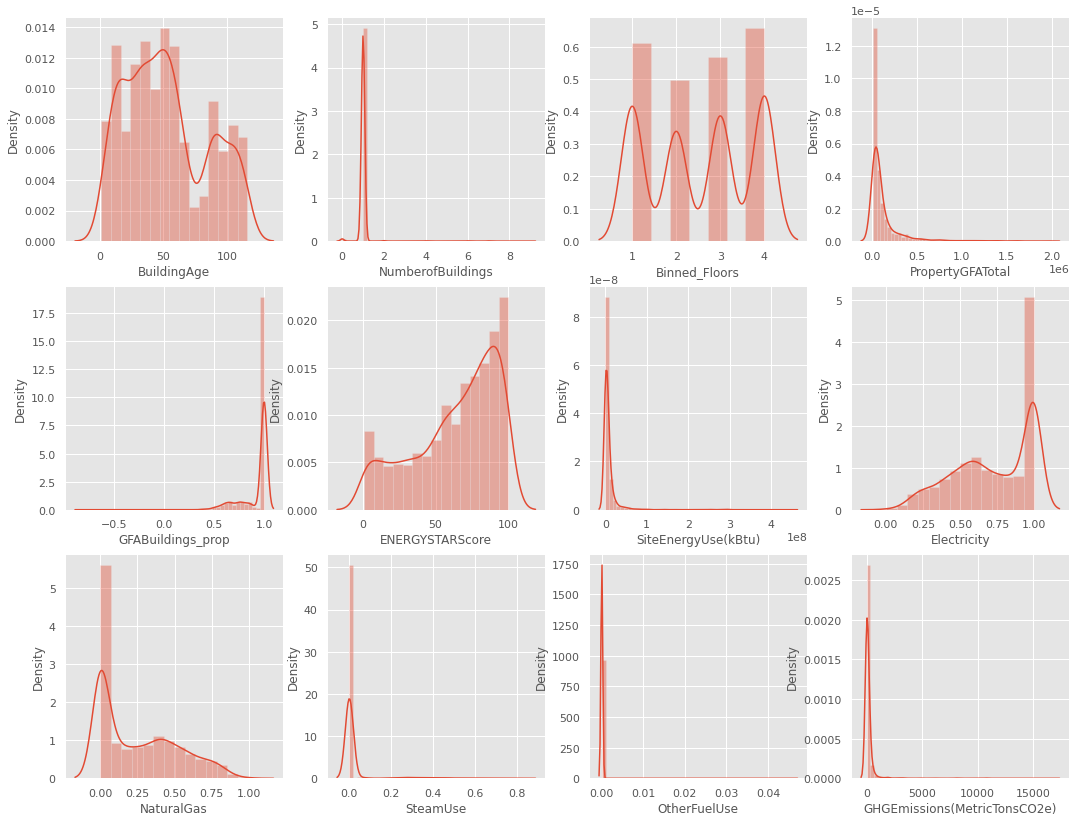

time: 4.77 s (started: 2021-01-31 12:40:57 +00:00)


In [77]:
def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(df, ["BuildingAge","NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"])


matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]


### 2.2 Univariate Analysis: Categorical Variables


[Text(0, 0, 'Office'),
 Text(0, 0, 'Warehouse'),
 Text(0, 0, 'Supermarket/Grocery/Retail Store'),
 Text(0, 0, 'School/University'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'Worship Facility'),
 Text(0, 0, 'Distribution Center'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Hospital/Laboratory'),
 Text(0, 0, 'Restaurant')]

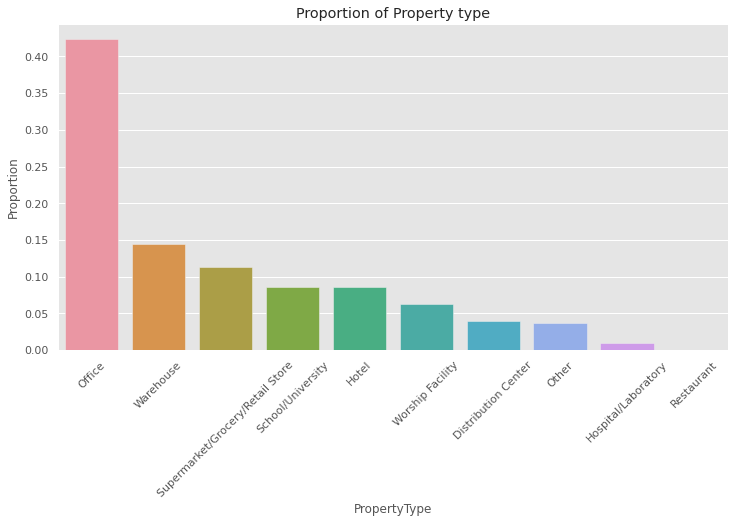

time: 375 ms (started: 2021-01-31 12:41:02 +00:00)


In [78]:
x, y = "PropertyType", "Proportion"

prop_df = (df["PrimaryPropertyType"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Property type')
g.set_xticklabels(g.get_xticklabels(),rotation=45)

[Text(0.5, 1.0, 'Proportion of Main Energy type')]

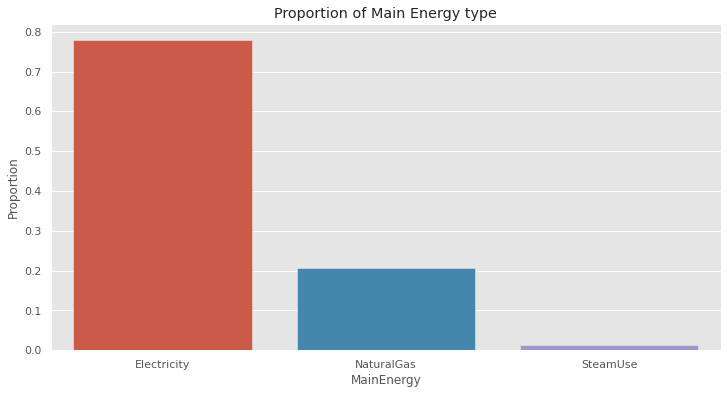

time: 224 ms (started: 2021-01-31 12:41:02 +00:00)


In [79]:
x, y = "MainEnergy", "Proportion"

prop_df = (df["MainEnergy"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Main Energy type')

From the above figures, we can notice the following:

- 40% of the buildings in the dataset are offices.
- Electricity is the main energy use by buildings

### 2.3 Multivariate Analysis: Categorical vs Numerical Variables 

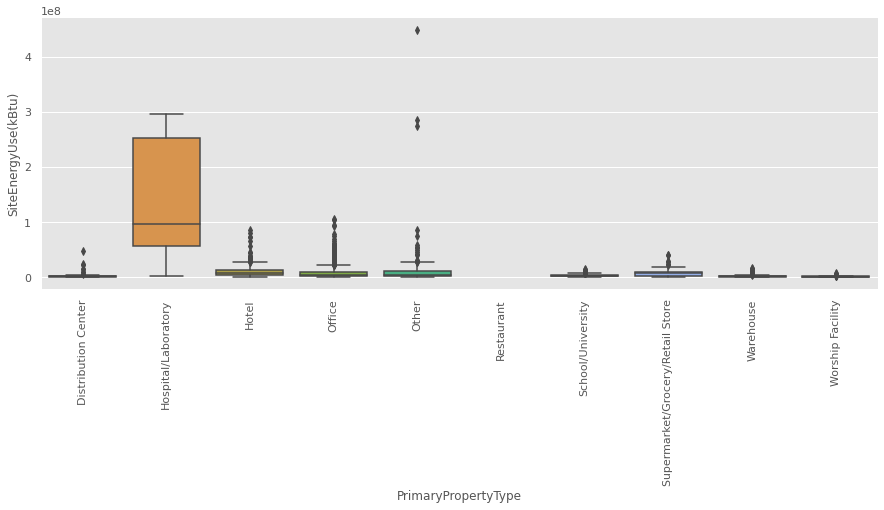

time: 511 ms (started: 2021-01-31 12:41:02 +00:00)


In [80]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

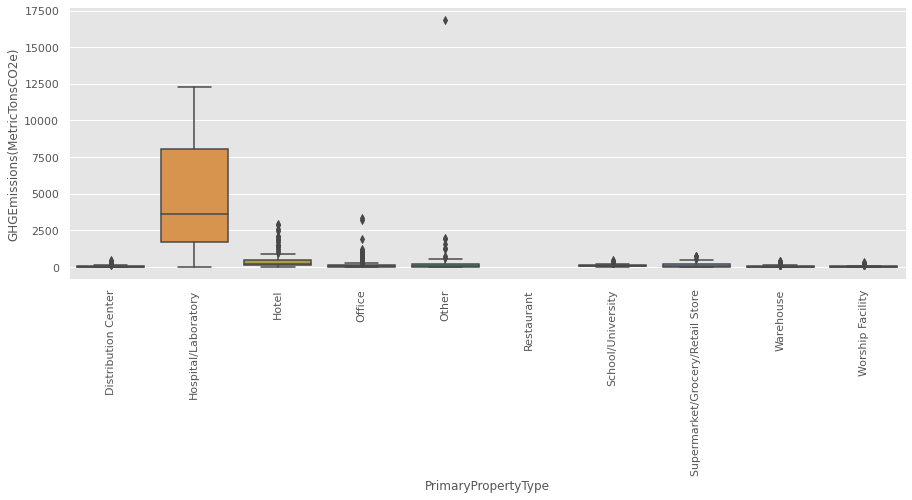

time: 378 ms (started: 2021-01-31 12:41:03 +00:00)


In [81]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

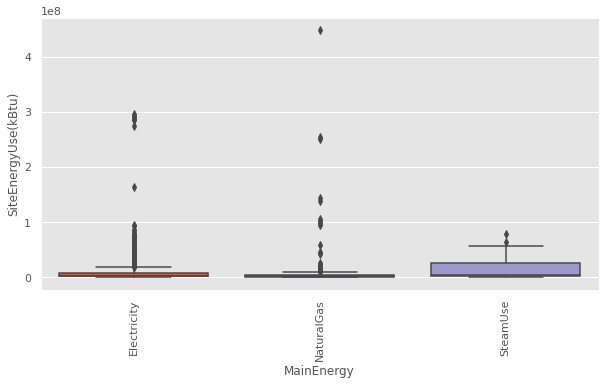

time: 202 ms (started: 2021-01-31 12:41:03 +00:00)


In [82]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

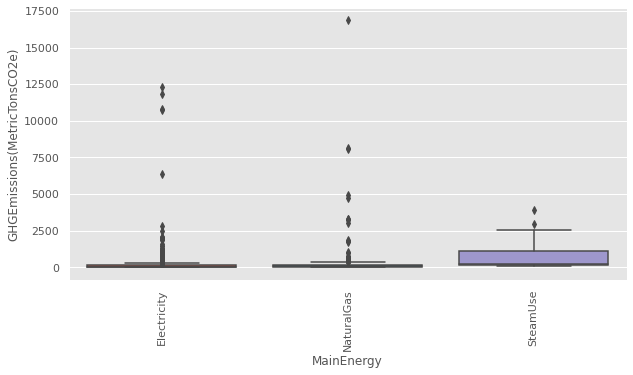

time: 220 ms (started: 2021-01-31 12:41:04 +00:00)


In [83]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

### 2.4 Geographical Analysis


#### *Heatmap*

In [84]:
def get_center_latlong(df):
    # get the center of my map for plotting
    centerlat = (df['Latitude'].max() + df['Latitude'].min()) / 2
    centerlong = (df['Longitude'].max() + df['Longitude'].min()) / 2
    return centerlat, centerlong

time: 3.01 ms (started: 2021-01-31 12:41:04 +00:00)


In [85]:
def generateBaseMap(center = get_center_latlong(df), default_zoom_start=11.5):
    base_map = folium.Map(location = center, control_scale=True, zoom_start=default_zoom_start)
    return base_map

time: 3.15 ms (started: 2021-01-31 12:41:04 +00:00)


In [86]:
from folium.plugins import HeatMap
df['count'] = 1
base_map = generateBaseMap()
HeatMap(data = df[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

time: 72.6 ms (started: 2021-01-31 12:41:04 +00:00)


#### *Choropleth Map*

In [87]:
boundary_file = '/content/drive/My Drive/OC_DataScientist/P4/Seattle-council-districts.geojson'
with open(boundary_file, 'r') as f:
    district_boundary = json.load(f)

time: 17.1 ms (started: 2021-01-31 12:41:04 +00:00)


In [88]:
# this line just to force our dataset zipcodes from numbers to strings so they match our geojson file
df['CouncilDistrictCode'] = pd.to_numeric(df.CouncilDistrictCode, errors='coerce')

# Grab my map center again using our created function (same as before)
center = get_center_latlong(df)


# Initialize Folium Map again (same as before)
seattle_map = folium.Map(location=center, zoom_start=11.5)

# Use the groupby method to have the mean of energy use by district
district_data = df.groupby('CouncilDistrictCode').aggregate(np.mean)
district_data.reset_index(inplace = True)

# Create choropleth map  
folium.Choropleth(
    geo_data=district_boundary,
    name='choropleth',
    data=district_data,
    columns=['CouncilDistrictCode', 'SiteEnergyUse(kBtu)'],
    key_on='feature.properties.district',
    fill_color='Spectral',
    fill_opacity=0.60,
      nan_fill_opacity=0,
    line_opacity=0.5,
    legend_name='Energy Use (kBtu)').add_to(seattle_map)

display(seattle_map)

time: 71 ms (started: 2021-01-31 12:41:04 +00:00)


From the above figures, we can notice the following:

- District 3 (Central District) and 7 (Downtown) have the highest average energy consumption in Seattle.

### 2.4 Correlation


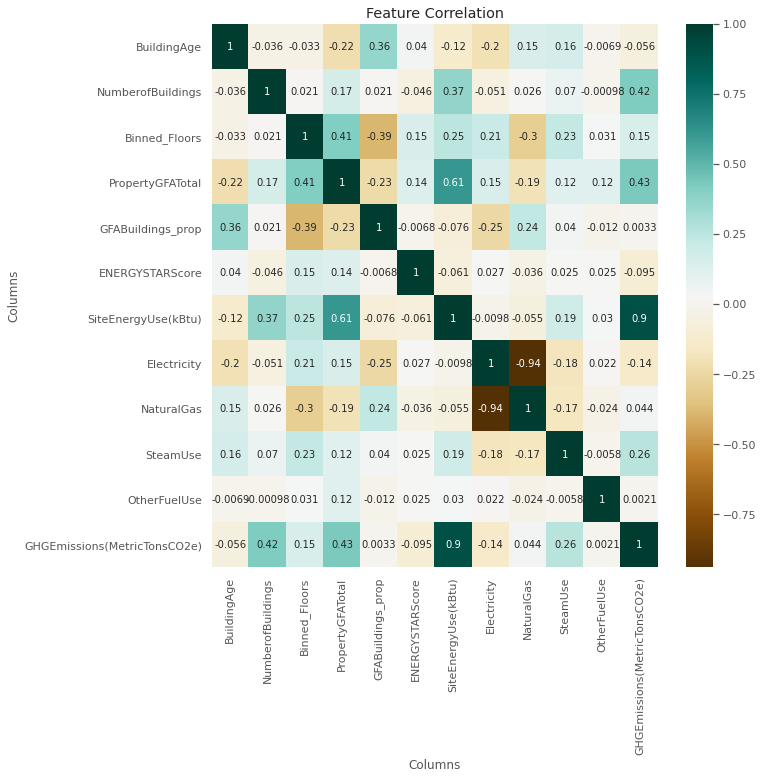

time: 982 ms (started: 2021-01-31 12:41:04 +00:00)


In [89]:
df_corr = df[["BuildingAge", "NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"]]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_corr.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

- High correlation between SiteEnergyUse(kBtu) and GHGEmissions(MetricTonsCO2e)
- High correlation between NaturalGas and Electricity
- Medium correlation between GHGEmissions and the number of floors
- Medium correlation between SiteEnergyUse or GHGEmissions and the number of buildings



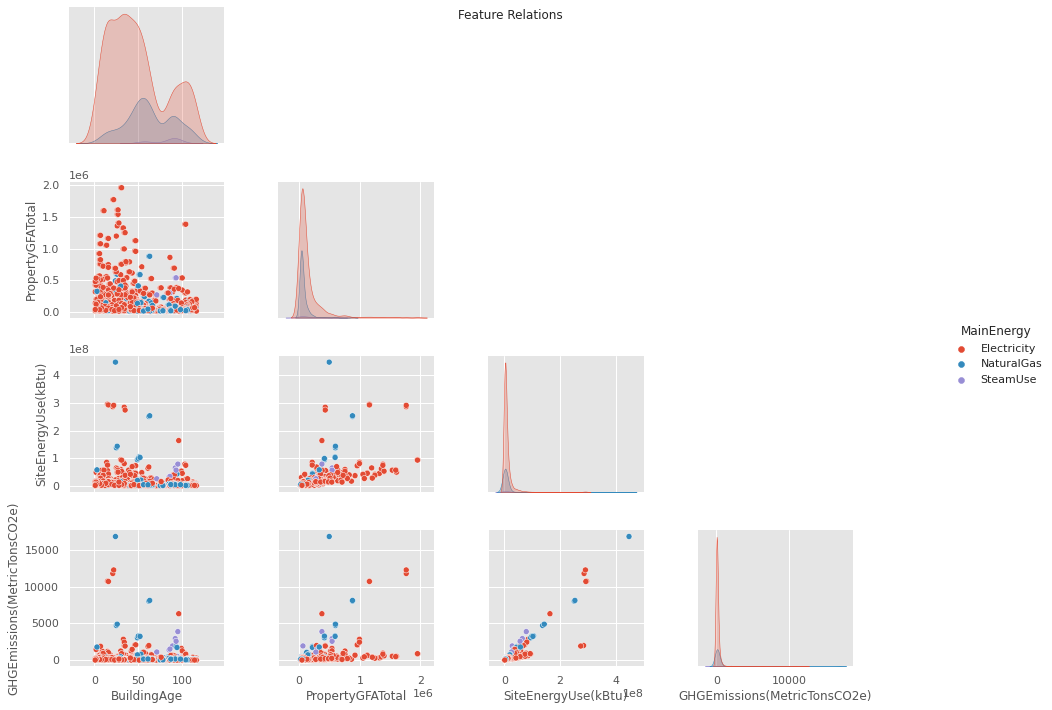

time: 6.29 s (started: 2021-01-31 12:41:05 +00:00)


In [90]:
g = sns.pairplot(df[["BuildingAge", "PropertyGFATotal", "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "MainEnergy"]], hue = 'MainEnergy', corner = True)
g.fig.suptitle('Feature Relations')
g.fig.set_size_inches(15,10)
plt.show()

## 5. Data Pre-Conditioning¶

In this section we will make our data ready for model training. This will include:

1. Transform our categorical column into numerical values.
2. Split data set into training and testing parts (80/20), while dropping the category column (string, and not going to be used to train the models), and separating cateogrical, where it will be used as labels.
3. We will try different splits of our dataset : with/without feature logging ; with.without duplicates.

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 3086
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OSEBuildingID                 2065 non-null   int64   
 1   DataYear                      2065 non-null   int64   
 2   PropertyName                  2065 non-null   category
 3   BuildingAge                   2065 non-null   int64   
 4   PrimaryPropertyType           2065 non-null   category
 5   NumberofBuildings             2065 non-null   float64 
 6   Binned_Floors                 2065 non-null   float64 
 7   PropertyGFATotal              2065 non-null   int64   
 8   GFABuildings_prop             2065 non-null   float64 
 9   ENERGYSTARScore               2065 non-null   float64 
 10  MainEnergy                    2065 non-null   category
 11  SiteEnergyUse(kBtu)           2065 non-null   float64 
 12  Electricity                   2065 non-null   fl

#### *Features Selection*

In [92]:
df_final = df[["OSEBuildingID", "DataYear", "BuildingAge", "PrimaryPropertyType", "NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "MainEnergy", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"]]

time: 7.07 ms (started: 2021-01-31 12:41:11 +00:00)


#### *PrimaryPropertyType Transform*

In [93]:
df_final = pd.get_dummies(df_final, drop_first=True)
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 3086
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   OSEBuildingID                                         2065 non-null   int64  
 1   DataYear                                              2065 non-null   int64  
 2   BuildingAge                                           2065 non-null   int64  
 3   NumberofBuildings                                     2065 non-null   float64
 4   Binned_Floors                                         2065 non-null   float64
 5   PropertyGFATotal                                      2065 non-null   int64  
 6   GFABuildings_prop                                     2065 non-null   float64
 7   ENERGYSTARScore                                       2065 non-null   float64
 8   SiteEnergyUse(kBtu)                                   2065

In [94]:
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final = df_final.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

df_final.head(5)

,OSEBuildingID,DataYear,BuildingAge,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),PrimaryPropertyType_Hospital/Laboratory,PrimaryPropertyType_Hotel,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Restaurant,PrimaryPropertyType_School/University,PrimaryPropertyType_Supermarket/Grocery/Retail Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,MainEnergy_NaturalGas,MainEnergy_SteamUse
0,1,2015,88,1.0,4.0,88434,1.000000,65.0,6981428.0,0.527995,0.182253,0.289773,0.0,249.43,0,1,0,0,0,0,0,0,0,0,0
1,2,2015,19,1.0,4.0,103566,0.854547,51.0,8354235.0,0.467477,0.532542,0.000000,0.0,263.51,0,1,0,0,0,0,0,0,0,1,0
2,3,2015,46,1.0,4.0,961990,1.000000,18.0,73130656.0,0.680459,0.050730,0.268839,0.0,2061.48,0,1,0,0,0,0,0,0,0,0,0
3,5,2015,89,1.0,4.0,61320,1.000000,1.0,28229320.0,0.098090,0.070915,0.830998,0.0,1936.34,0,1,0,0,0,0,0,0,0,0,1
4,8,2015,35,1.0,4.0,119890,0.896071,67.0,14829099.0,0.409077,0.590940,0.000000,0.0,507.70,0,1,0,0,0,0,0,0,0,1,0


time: 27.9 ms (started: 2021-01-31 12:41:11 +00:00)


#### *Data Split 1: With Duplicates ; Without logging of high variance features*

In [95]:
y = df_final['SiteEnergyUse(kBtu)']
X = df_final.drop(['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)','OSEBuildingID', 'DataYear'], axis=1)
seed = 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

time: 8.2 ms (started: 2021-01-31 12:41:11 +00:00)


#### *Data Split 2: With Duplicates ; With logging of high variance features*

In [96]:
df_final.var().sort_values(ascending=False).head(5)

SiteEnergyUse(kBtu)             5.440853e+14
PropertyGFATotal                4.358025e+10
OSEBuildingID                   1.689412e+08
GHGEmissions(MetricTonsCO2e)    5.681782e+05
BuildingAge                     1.007742e+03
dtype: float64

time: 15.2 ms (started: 2021-01-31 12:41:11 +00:00)


In [97]:
df_final2 = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final2[i + '_log'] = np.log(df_final2[i])
    df_final2.drop(i, axis=1, inplace=True)

df_final2 = df_final2.reset_index()
y2 = df_final2['SiteEnergyUse(kBtu)_log']
X2 = df_final2.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','OSEBuildingID', 'DataYear'], axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=seed)

time: 22.1 ms (started: 2021-01-31 12:41:11 +00:00)


#### *Data Split 3: Without Duplicates ; Without logging of high variance features*

In [98]:
df_final3 = df_final.sort_values(by=['OSEBuildingID', 'DataYear']).drop_duplicates('OSEBuildingID', keep='last')
y3 = df_final3['SiteEnergyUse(kBtu)']
X3 = df_final3.drop(['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)','OSEBuildingID', 'DataYear'], axis=1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=seed)

time: 15.1 ms (started: 2021-01-31 12:41:12 +00:00)


#### *Data Split 4: Without Duplicates ; With logging of high variance features*

In [99]:
df_final4 = df_final2.sort_values(by=['OSEBuildingID', 'DataYear']).drop_duplicates('OSEBuildingID', keep='last')
y4 = df_final4['SiteEnergyUse(kBtu)_log']
X4 = df_final4.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','OSEBuildingID', 'DataYear'], axis=1)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=seed)

time: 20.1 ms (started: 2021-01-31 12:41:12 +00:00)


### Functions

In [100]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('Ridge', Ridge(random_state=42)), 
          ('Lasso', Lasso(random_state=42)),
          ('RF', RandomForestRegressor(random_state=42)),
          ('XGBR', XGBRegressor(objective ='reg:linear', verbosity = 0, random_state=42))
          ]

    results = []
    names = []
    scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_squared_error']

    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    
        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
    
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)

    return final

time: 24.9 ms (started: 2021-01-31 12:41:12 +00:00)


## 6. Modelization of the energy use


In [103]:
final = run_exps(X_train, y_train, X_test, y_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (With duplicates, No logging):')
df_compare

Model Performance Comparison (With duplicates, No logging):


model,Lasso,RF,Ridge,XGBR
fit_time,4.256573e-02,7.974812e-01,4.706240e-03,1.093470e-01
score_time,3.043365e-03,1.611619e-02,2.726269e-03,3.233576e-03
test_r2,5.305125e-01,7.377564e-01,5.350520e-01,7.371985e-01
test_neg_root_mean_squared_error,-1.532223e+07,-1.196203e+07,-1.531118e+07,-1.182243e+07
test_neg_mean_squared_error,-2.797970e+14,-1.934585e+14,-2.794525e+14,-2.051576e+14


time: 6.1 s (started: 2021-01-31 12:41:12 +00:00)


In [104]:
final = run_exps(X2_train, y2_train, X2_test, y2_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (With duplicates, With logging):')
df_compare

Model Performance Comparison (With duplicates, With logging):


model,Lasso,RF,Ridge,XGBR
fit_time,0.004318,0.794452,0.004734,0.122250
score_time,0.002635,0.014515,0.002767,0.003534
test_r2,0.497371,0.875779,0.690216,0.872519
test_neg_root_mean_squared_error,-0.902462,-0.447326,-0.708140,-0.453785
test_neg_mean_squared_error,-0.816873,-0.200617,-0.503653,-0.207020


time: 5.94 s (started: 2021-01-31 12:41:18 +00:00)


In [105]:
final = run_exps(X3_train, y3_train, X3_test, y3_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (No duplicates, No logging):')
df_compare

Model Performance Comparison (No duplicates, No logging):


model,Lasso,RF,Ridge,XGBR
fit_time,2.249532e-02,4.665843e-01,4.046869e-03,6.698651e-02
score_time,2.733469e-03,1.118603e-02,2.544212e-03,3.166771e-03
test_r2,3.813119e-01,4.940571e-01,4.604869e-01,7.431385e-02
test_neg_root_mean_squared_error,-1.460594e+07,-1.420013e+07,-1.456675e+07,-1.669698e+07
test_neg_mean_squared_error,-3.044053e+14,-2.940634e+14,-3.054730e+14,-3.531052e+14


time: 3.62 s (started: 2021-01-31 12:41:24 +00:00)


In [106]:
final = run_exps(X4_train, y4_train, X4_test, y4_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (No duplicates, With logging):')
df_compare

Model Performance Comparison (No duplicates, With logging):


model,Lasso,RF,Ridge,XGBR
fit_time,0.004316,0.473904,0.003710,0.071258
score_time,0.002745,0.011542,0.002418,0.003016
test_r2,0.497358,0.819913,0.687018,0.841352
test_neg_root_mean_squared_error,-0.902890,-0.539546,-0.713009,-0.506588
test_neg_mean_squared_error,-0.823945,-0.293084,-0.515149,-0.259114


time: 3.58 s (started: 2021-01-31 12:41:27 +00:00)


In [107]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')

    time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

time: 42.5 ms (started: 2021-01-31 12:41:31 +00:00)


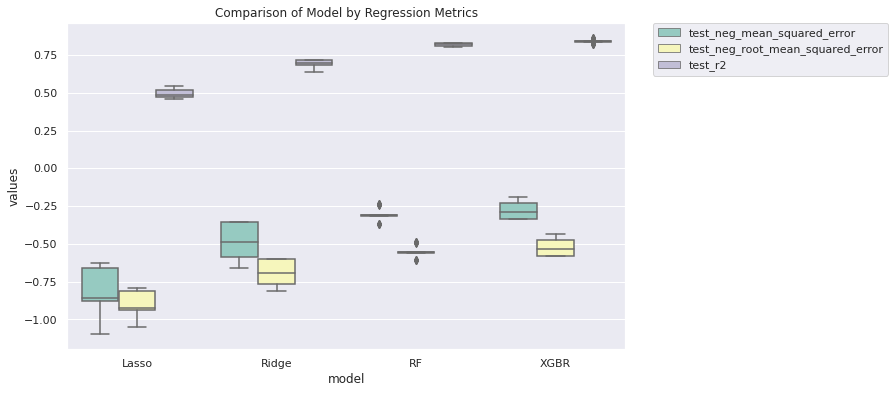

time: 1.26 s (started: 2021-01-31 12:41:31 +00:00)


In [108]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Regression Metrics')
plt.savefig('./benchmark_models_performance.png',dpi=300)

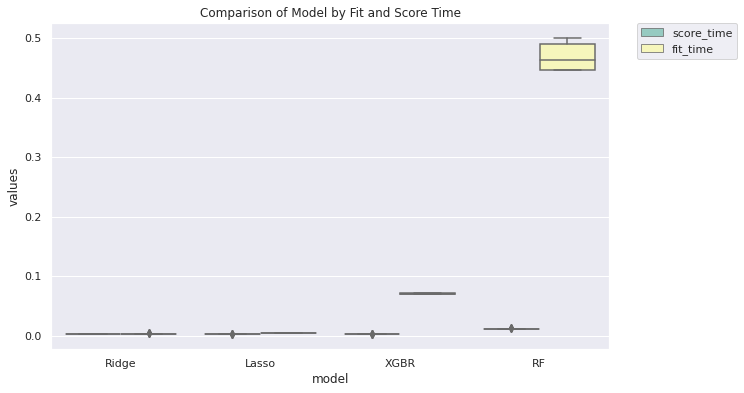

time: 1.09 s (started: 2021-01-31 12:41:32 +00:00)


In [109]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

##### Optimization
We will use grid search in order to obtain good parameters for our XGB regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimize are:

- n-estimators
- subsample
- reg_alpha
- max_features
- bootstrap

In [110]:
xgbr_elec_param_grid = {'objective':['reg:squarederror'],
    'max_depth': [5, 10, 20],
    'subsample': [0.8, 0.9, 1],
    'reg_alpha': [0.1, 0.3, 1],
    'n_estimators': [100, 200, 400]}

time: 2.01 ms (started: 2021-01-31 12:41:33 +00:00)


In [111]:
xgbr_elec_grid = GridSearchCV(estimator= XGBRegressor(), param_grid = xgbr_elec_param_grid,  cv=5, verbose=0)

time: 1.55 ms (started: 2021-01-31 12:41:33 +00:00)


In [113]:
xgbr_elec_grid.fit(X2_train,y2_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [100, 200, 400],
                       

time: 6min 13s (started: 2021-01-31 12:41:53 +00:00)


In [114]:
xgbr_elec_grid.best_params_

{'max_depth': 5,
 'n_estimators': 400,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'subsample': 0.9}

time: 2.79 ms (started: 2021-01-31 12:48:07 +00:00)


In [115]:
xgbr_elec_grid_opti = xgbr_elec_grid.best_estimator_
xgbr_elec_grid_opti

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, verbosity=1)

time: 4.01 ms (started: 2021-01-31 12:48:07 +00:00)


In [116]:
xgbr_elec_grid_train_predictions = xgbr_elec_grid_opti.predict(X2_train)
xgbr_elec_grid_test_predictions = xgbr_elec_grid_opti.predict(X2_test)

time: 62.9 ms (started: 2021-01-31 12:48:07 +00:00)


Train MAE: 0.0531925819797206
Train R2_Score:  0.996757029986605

Test MAE: 0.25853876747382537
Test RMSE: 0.37362006339294623
Test R2_Score:  0.9210473325523392


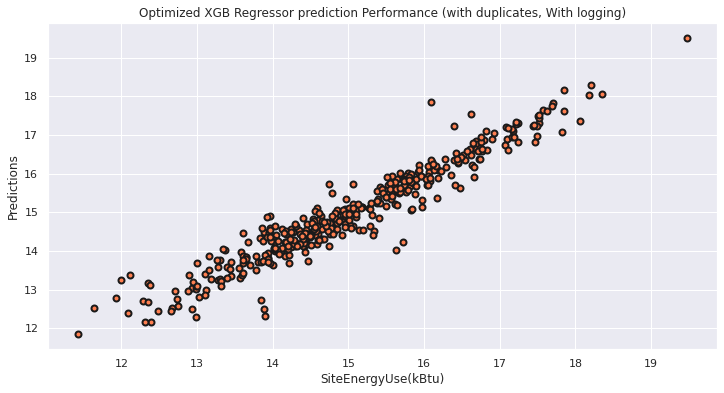

time: 332 ms (started: 2021-01-31 12:48:07 +00:00)


In [117]:
print('Train MAE:', mean_absolute_error(y2_train, xgbr_elec_grid_train_predictions))
print('Train R2_Score: ', r2_score(y2_train, xgbr_elec_grid_train_predictions))
print()
print('Test MAE:', mean_absolute_error(y2_test, xgbr_elec_grid_test_predictions))
print('Test RMSE:', np.sqrt(mean_squared_error(y2_test, xgbr_elec_grid_test_predictions)))
print('Test R2_Score: ', r2_score(y2_test, xgbr_elec_grid_test_predictions))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y2_test,xgbr_elec_grid_test_predictions,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Optimized XGB Regressor prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

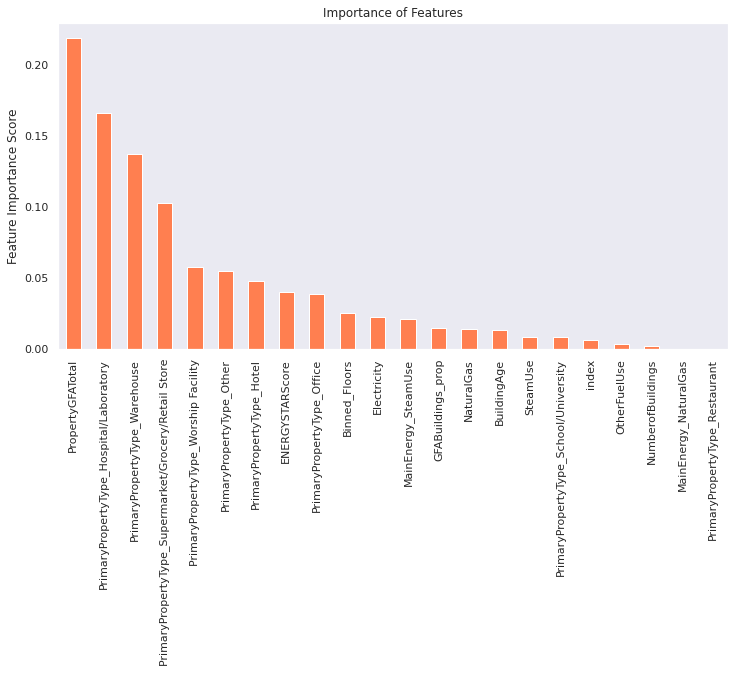

time: 437 ms (started: 2021-01-31 12:48:09 +00:00)


In [118]:
feat_imp = pd.Series(xgbr_elec_grid.best_estimator_.feature_importances_, list(X2_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

## 7. Modelization of the CO2


In [119]:
df_final_co2 = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final_co2[i + '_log'] = np.log(df_final_co2[i])
    df_final_co2.drop(i, axis=1, inplace=True)

y = df_final_co2['GHGEmissions(MetricTonsCO2e)_log']
X = df_final_co2.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','OSEBuildingID', 'DataYear'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

time: 20.2 ms (started: 2021-01-31 12:48:10 +00:00)


In [120]:
final = run_exps(X_train, y_train, X_test, y_test)
df_compare = final.groupby(['model']).mean().T
df_compare

model,Lasso,RF,Ridge,XGBR
fit_time,0.004188,0.682677,0.004988,0.114212
score_time,0.002487,0.014307,0.002805,0.003472
test_r2,0.310022,0.892245,0.748136,0.892927
test_neg_root_mean_squared_error,-1.215023,-0.476733,-0.733028,-0.476175
test_neg_mean_squared_error,-1.479939,-0.228116,-0.539249,-0.227622


time: 5.17 s (started: 2021-01-31 12:48:10 +00:00)


In [121]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')

    time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

time: 32.3 ms (started: 2021-01-31 12:48:15 +00:00)


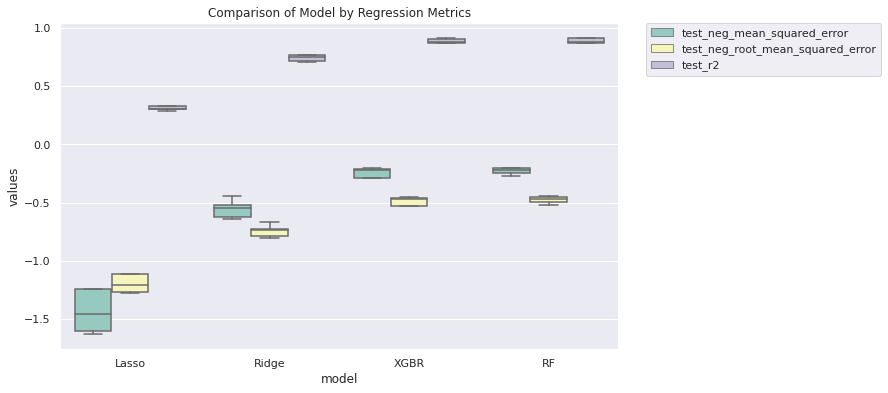

time: 1.29 s (started: 2021-01-31 12:48:15 +00:00)


In [122]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Regression Metrics')
plt.savefig('./benchmark_models_performance.png',dpi=300)

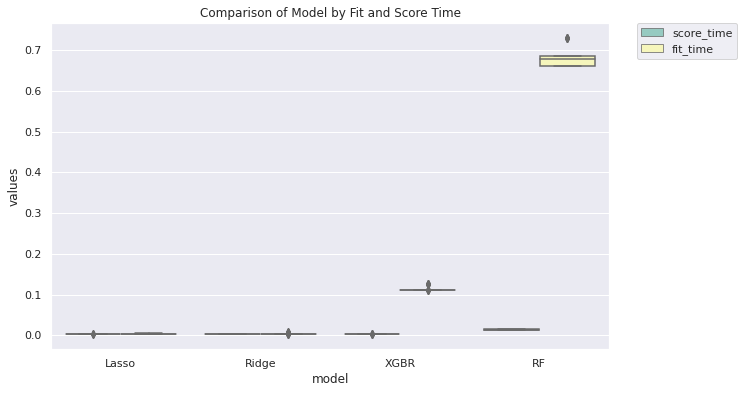

time: 1.1 s (started: 2021-01-31 12:48:16 +00:00)


In [123]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

##### Optimization
We will use grid search in order to obtain good parameters for our XGB regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimize are:

- n-estimators
- min_samples_leaf
- max_depth
- max_features
- bootstrap

In [124]:
xgbr_co2_param_grid = {'objective':['reg:squarederror'],
    'max_depth': [5, 10, 20],
    'subsample': [0.8, 0.9, 1],
    'reg_alpha': [0.1, 0.3, 1],
    'n_estimators': [100, 200, 400]}

time: 8.03 ms (started: 2021-01-31 12:48:18 +00:00)


In [125]:
xgbr_co2_grid = GridSearchCV(estimator= XGBRegressor(), param_grid = rf_param_grid,  cv=5, verbose=0)

time: 1.8 ms (started: 2021-01-31 12:48:18 +00:00)


In [126]:
 xgbr_co2_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [100, 200, 400],
                       

time: 6min 11s (started: 2021-01-31 12:48:18 +00:00)


In [127]:
xgbr_co2_grid.best_params_

{'max_depth': 5,
 'n_estimators': 400,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.3,
 'subsample': 0.8}

time: 3.01 ms (started: 2021-01-31 12:54:29 +00:00)


In [128]:
xgbr_co2_grid_opti = xgbr_co2_grid.best_estimator_
xgbr_co2_grid_opti

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

time: 4.37 ms (started: 2021-01-31 12:54:29 +00:00)


In [129]:
xgbr_co2_grid_train_predictions = xgbr_co2_grid_opti.predict(X_train)
xgbr_co2_grid_test_predictions = xgbr_co2_grid_opti.predict(X_test)

time: 56.2 ms (started: 2021-01-31 12:54:29 +00:00)


Train MAE: 0.07961524542963373
Train R2_Score:  0.9945298225516637

Test MAE: 0.25587462462280763
Test RMSE: 0.3722632308479833
Test R2_Score:  0.9397551263913374


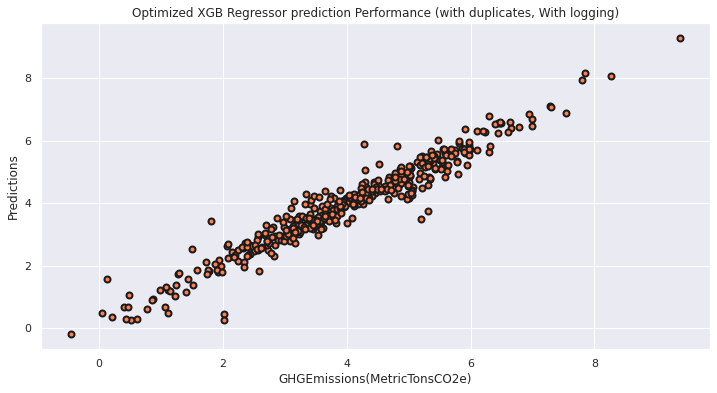

time: 295 ms (started: 2021-01-31 13:00:54 +00:00)


In [131]:
print('Train MAE:', mean_absolute_error(y_train, xgbr_co2_grid_train_predictions))
print('Train R2_Score: ', r2_score(y_train, xgbr_co2_grid_train_predictions))
print()
print('Test MAE:', mean_absolute_error(y_test, xgbr_co2_grid_test_predictions))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, xgbr_co2_grid_test_predictions)))
print('Test R2_Score: ', r2_score(y_test, xgbr_co2_grid_test_predictions))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y_test,xgbr_co2_grid_test_predictions,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('GHGEmissions(MetricTonsCO2e)') 
plt.ylabel('Predictions') 
plt.title('Optimized XGB Regressor prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

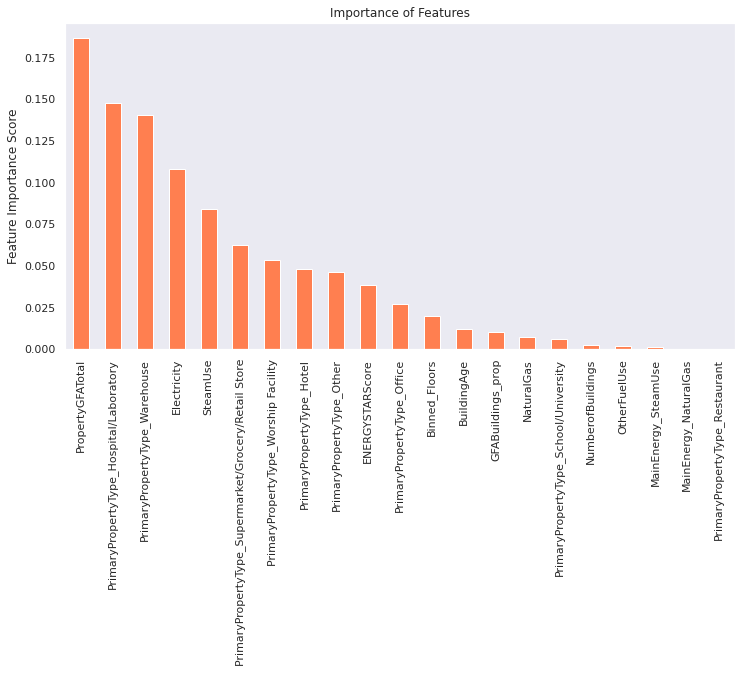

time: 453 ms (started: 2021-01-31 13:01:26 +00:00)


In [133]:
feat_imp = pd.Series(xgbr_co2_grid.best_estimator_.feature_importances_, list(X_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

## 8. Modelization of the CO2 without the energy star score


In [134]:
df_final_co2_ES = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final_co2_ES[i + '_log'] = np.log(df_final_co2_ES[i])
    df_final_co2_ES.drop(i, axis=1, inplace=True)

y = df_final_co2_ES['GHGEmissions(MetricTonsCO2e)_log']
X = df_final_co2_ES.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','ENERGYSTARScore', 'OSEBuildingID', 'DataYear'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

time: 16.5 ms (started: 2021-01-31 13:04:53 +00:00)


In [135]:
xgbr_co2_ES_param_grid = {'objective':['reg:squarederror'],
    'max_depth': [5],
    'subsample': [0.8],
    'reg_alpha': [0.3],
    'n_estimators': [400]}

time: 6.36 ms (started: 2021-01-31 13:04:56 +00:00)


In [136]:
xgbr_co2_ES_grid = GridSearchCV(estimator= XGBRegressor(), param_grid = xgbr_co2_ES_param_grid,  cv=5, verbose=0)

time: 1.45 ms (started: 2021-01-31 13:05:00 +00:00)


In [137]:
 xgbr_co2_ES_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5], 'n_estimators': [400],
                         'objective': ['reg:squarederror'], 'reg_a

time: 4.83 s (started: 2021-01-31 13:05:03 +00:00)


In [138]:
xgbr_co2_ES_grid.best_params_

{'max_depth': 5,
 'n_estimators': 400,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.3,
 'subsample': 0.8}

time: 4.03 ms (started: 2021-01-31 13:05:08 +00:00)


In [139]:
xgbr_co2_ES_grid_opti = xgbr_co2_ES_grid.best_estimator_
xgbr_co2_ES_grid_opti

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

time: 3.89 ms (started: 2021-01-31 13:05:13 +00:00)


In [140]:
xgbr_co2_ES_grid_train_predictions = xgbr_co2_ES_grid_opti.predict(X_train)
xgbr_co2_ES_grid_test_predictions = xgbr_co2_ES_grid_opti.predict(X_test)

time: 58.9 ms (started: 2021-01-31 13:05:16 +00:00)


Train MAE: 0.10976482250232117
Train R2_Score:  0.9895093609222146

Test MAE: 0.33672214226057406
Test RMSE: 0.48323913126144574
Test R2_Score:  0.898481777990209


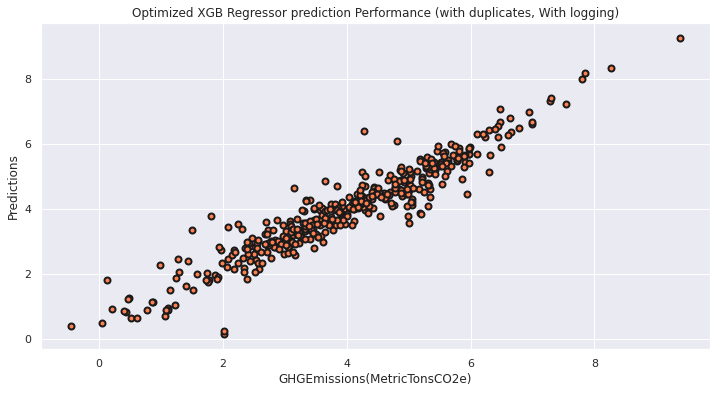

time: 313 ms (started: 2021-01-31 13:05:20 +00:00)


In [141]:
print('Train MAE:', mean_absolute_error(y_train, xgbr_co2_ES_grid_train_predictions))
print('Train R2_Score: ', r2_score(y_train, xgbr_co2_ES_grid_train_predictions))
print()
print('Test MAE:', mean_absolute_error(y_test, xgbr_co2_ES_grid_test_predictions))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, xgbr_co2_ES_grid_test_predictions)))
print('Test R2_Score: ', r2_score(y_test, xgbr_co2_ES_grid_test_predictions))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y_test,xgbr_co2_ES_grid_test_predictions,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('GHGEmissions(MetricTonsCO2e)') 
plt.ylabel('Predictions') 
plt.title('Optimized XGB Regressor prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

## 9. Conclusion


In this project, we used Seattle dataset to build a building electrical consumption and CO2 emissions predictor. 4 different learning regressors (Lasso, Ridge, Random Forest, and XGB) were tested, and we have acheived the best prediction performance using XGB, followed by Random Forest.

The best prediction performance was acheived using Random Forest regressor, using features logging and duplicates datas in the dataset, and resulted in the following metrics:

Energy Use : 
- Mean Absolute Error (MAE): 0.2585
- Root mean squared error (RMSE): 0.3736
- R-squared Score (R2_Score): 0.9210

CO2 Emissions : 
- Mean Absolute Error (MAE): 0.2558
- Root mean squared error (RMSE): 0.3722
- R-squared Score (R2_Score): 0.9397

The tests of the different models allowed to determine that the energy star score allowed to have a model with better performances however the performances remain good without the energy star score too.